# Smart Wearables -- Bonsai Tree Classification on stream data

## 1. Introduction & Library Imports 

In [24]:
import numpy as np
from sklearn.metrics.classification import accuracy_score, recall_score, f1_score
import scipy.stats as st
import sys
from sklearn.model_selection import train_test_split
from bonsai.base.regtree import RegTree
from bonsai.base.alphatree import AlphaTree
from bonsai.base.c45tree import C45Tree
from bonsai.base.ginitree import GiniTree
from bonsai.base.xgbtree import XGBTree
from bonsai.base.friedmantree import FriedmanTree
from bonsai.ensemble.randomforests import RandomForests
from bonsai.ensemble.paloboost import PaloBoost
from bonsai.ensemble.gbm import GBM
import copy
import time

## 2. Data Gathering

In [56]:
data_input_file = 'data/SNOW/MHEALTH.npz'
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
tmp = np.load(data_input_file)
np.load = np_load_old

In [57]:
X = tmp['X']
X = X[:, 0, :, :]
y = tmp['y']
folds = tmp['folds']

In [58]:
n_class = y.shape[1]
y = np.argmax(y, axis=1)
print('Hancrafted Template 2017 {}'.format(data_input_file))

Hancrafted Template 2017 data/SNOW/MHEALTH.npz


## 3. Feature Engineering

In [10]:
def A(sample):
    feat = []
    for col in range(0,sample.shape[1]):
        average = np.average(sample[:,col])
        feat.append(average)

    return feat

def SD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        std = np.std(sample[:, col])
        feat.append(std)

    return feat

def AAD(sample):
    feat = []
    for col in range(0, sample.shape[1]):
        data = sample[:, col]
        add = np.mean(np.absolute(data - np.mean(data)))
        feat.append(add)

    return feat

def ARA(sample):
    #Average Resultant Acceleration[1]:
    # Average of the square roots of the sum of the values of each axis squared √(xi^2 + yi^2+ zi^2) over the ED
    feat = []
    sum_square = 0
    sample = np.power(sample, 2)
    for col in range(0, sample.shape[1]):
        sum_square = sum_square + sample[:, col]

    sample = np.sqrt(sum_square)
    average = np.average(sample)
    feat.append(average)
    return feat

def TBP(sample):
    from scipy import signal
    feat = []
    sum_of_time = 0
    for col in range(0, sample.shape[1]):
        data = sample[:, col]
        peaks = signal.find_peaks_cwt(data, np.arange(1,4))

        feat.append(peaks)

    return feat

def feature_extraction(X):
    #Extracts the features, as mentioned by Catal et al. 2015
    # Average - A,
    # Standard Deviation - SD,
    # Average Absolute Difference - AAD,
    # Average Resultant Acceleration - ARA(1),
    # Time Between Peaks - TBP
    X_tmp = []
    for sample in X:
        features = A(copy.copy(sample))
        features = np.hstack((features, A(copy.copy(sample))))
        features = np.hstack((features, SD(copy.copy(sample))))
        features = np.hstack((features, AAD(copy.copy(sample))))
        features = np.hstack((features, ARA(copy.copy(sample))))
        #features = np.hstack((features, TBP(sample)))
        X_tmp.append(features)

    X = np.array(X_tmp)
    return X


## 4. RegTree

In [45]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

        #Your train goes here. For instance:
    #X_train=X_train.transpose(0,1,2).reshape(X_train.shape[0],-1)
    #X_test=X_test.transpose(0,1,2).reshape(X_test.shape[0],-1)
    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = RegTree(max_depth=8)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)
    



    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.9729] Recall[0.9743] F1[0.9744] at fold[0]
______________________________________________________
Accuracy[0.9844] Recall[0.9855] F1[0.9847] at fold[1]
______________________________________________________
Accuracy[1.0000] Recall[1.0000] F1[1.0000] at fold[2]
______________________________________________________
Accuracy[0.9766] Recall[0.9783] F1[0.9773] at fold[3]
______________________________________________________
Accuracy[0.9961] Recall[0.9962] F1[0.9962] at fold[4]
______________________________________________________
Accuracy[0.9882] Recall[0.9807] F1[0.9845] at fold[5]
______________________________________________________
Accuracy[0.9882] Recall[0.9891] F1[0.9891] at fold[6]
______________________________________________________
Accuracy[0.9882] Recall[0.9888] F1[0.9886] at fold[7]
______________________________________________________
Accuracy[0.9804] Recall[0.9648] F1[0.9714] at fold[8]
______________________________________________________
Accuracy[0.9961] Re

In [46]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.9871] IC [0.9820, 0.9922]
Mean Recall[0.9854] IC [0.9790, 0.9918]
Mean F1[0.9862] IC [0.9806, 0.9919]
Mean size[0.853]
Mean training time[942.159]
Mean prediction time[0.150]


## 5. XGBTree

In [59]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = XGBTree(max_depth=10,min_samples_split=1,min_samples_leaf=1)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)
    

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.9806] Recall[0.9816] F1[0.9819] at fold[0]
______________________________________________________
Accuracy[0.9961] Recall[0.9964] F1[0.9963] at fold[1]
______________________________________________________
Accuracy[1.0000] Recall[1.0000] F1[1.0000] at fold[2]
______________________________________________________
Accuracy[0.9922] Recall[0.9928] F1[0.9927] at fold[3]
______________________________________________________
Accuracy[0.9961] Recall[0.9964] F1[0.9964] at fold[4]
______________________________________________________
Accuracy[0.9843] Recall[0.9771] F1[0.9808] at fold[5]
______________________________________________________
Accuracy[0.9961] Recall[0.9964] F1[0.9964] at fold[6]
______________________________________________________
Accuracy[1.0000] Recall[1.0000] F1[1.0000] at fold[7]
______________________________________________________
Accuracy[0.9882] Recall[0.9726] F1[0.9792] at fold[8]
______________________________________________________
Accuracy[0.9921] Re

In [60]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.9926] IC [0.9888, 0.9963]
Mean Recall[0.9906] IC [0.9849, 0.9963]
Mean F1[0.9916] IC [0.9870, 0.9963]
Mean size[0.976]
Mean training time[1248.039]
Mean prediction time[0.163]


## 6. FriedmanTree

In [49]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = FriedmanTree(max_depth=8,min_samples_split=1,min_samples_leaf=1)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.9806] Recall[0.9816] F1[0.9819] at fold[0]
______________________________________________________
Accuracy[0.9961] Recall[0.9964] F1[0.9962] at fold[1]
______________________________________________________
Accuracy[0.9922] Recall[0.9845] F1[0.9883] at fold[2]
______________________________________________________
Accuracy[0.9844] Recall[0.9853] F1[0.9853] at fold[3]
______________________________________________________
Accuracy[0.9961] Recall[0.9964] F1[0.9964] at fold[4]
______________________________________________________
Accuracy[0.9922] Recall[0.9843] F1[0.9880] at fold[5]
______________________________________________________
Accuracy[0.9961] Recall[0.9964] F1[0.9964] at fold[6]
______________________________________________________
Accuracy[0.9961] Recall[0.9962] F1[0.9961] at fold[7]
______________________________________________________
Accuracy[0.9882] Recall[0.9726] F1[0.9792] at fold[8]
______________________________________________________
Accuracy[0.9803] Re

In [50]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.9902] IC [0.9865, 0.9940]
Mean Recall[0.9875] IC [0.9826, 0.9923]
Mean F1[0.9889] IC [0.9848, 0.9929]
Mean size[0.825]
Mean training time[880.433]
Mean prediction time[0.143]


## 7. PaloBoost

In [52]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

        #Your train goes here. For instance:
    #X_train=X_train.transpose(0,1,2).reshape(X_train.shape[0],-1)
    #X_test=X_test.transpose(0,1,2).reshape(X_test.shape[0],-1)
    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = PaloBoost(n_estimators=100,max_depth=5)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.9612] Recall[0.9636] F1[0.9630] at fold[0]
______________________________________________________
Accuracy[0.9922] Recall[0.9928] F1[0.9924] at fold[1]
______________________________________________________
Accuracy[0.9766] Recall[0.9776] F1[0.9773] at fold[2]
______________________________________________________
Accuracy[0.9844] Recall[0.9771] F1[0.9805] at fold[3]
______________________________________________________
Accuracy[0.9804] Recall[0.9811] F1[0.9805] at fold[4]
______________________________________________________
Accuracy[0.9608] Recall[0.9629] F1[0.9627] at fold[5]
______________________________________________________
Accuracy[0.9804] Recall[0.9814] F1[0.9812] at fold[6]
______________________________________________________
Accuracy[0.9922] Recall[0.9924] F1[0.9923] at fold[7]
______________________________________________________
Accuracy[0.9765] Recall[0.9691] F1[0.9690] at fold[8]
______________________________________________________
Accuracy[0.9724] Re

In [53]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.9777] IC [0.9714, 0.9840]
Mean Recall[0.9772] IC [0.9712, 0.9832]
Mean F1[0.9773] IC [0.9712, 0.9834]
Mean size[0.211]
Mean training time[25474.252]
Mean prediction time[6.023]


## 8. GBM

In [54]:
avg_acc = []
avg_recall = []
avg_f1 = []
avg_ttime=[]
avg_ptime=[]
avg_size=[]
for i in range(0, len(folds)):
    train_idx = folds[i][0]
    test_idx = folds[i][1]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

        #Your train goes here. For instance:
    #X_train=X_train.transpose(0,1,2).reshape(X_train.shape[0],-1)
    #X_test=X_test.transpose(0,1,2).reshape(X_test.shape[0],-1)
    X_train = feature_extraction(X_train)
    X_test = feature_extraction(X_test)      
        
    method = GBM(n_estimators=100,max_depth=5)
    t0=time.time()
    method.fit(X_train, y_train)
    avg_ttime.append(time.time()-t0)
            #Your testing goes here. For instance:
    t1=time.time()
    y_pred = method.predict(X_test)
    avg_ptime.append(time.time()-t1)
    y_pred=np.round(y_pred,0)
    y_pred=y_pred.astype(int)
    v=method.dump()
    avg_size.append(round(v.__sizeof__()/1024,3))

    acc_fold = accuracy_score(y_test, y_pred)
    avg_acc.append(acc_fold)

    recall_fold = recall_score(y_test, y_pred, average='macro')
    avg_recall.append(recall_fold)

    f1_fold  = f1_score(y_test, y_pred, average='macro')
    avg_f1.append(f1_fold)

    print('Accuracy[{:.4f}] Recall[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, f1_fold ,i))
    print('______________________________________________________')

Accuracy[0.9806] Recall[0.9817] F1[0.9815] at fold[0]
______________________________________________________
Accuracy[0.9805] Recall[0.9814] F1[0.9812] at fold[1]
______________________________________________________
Accuracy[0.9844] Recall[0.9848] F1[0.9849] at fold[2]
______________________________________________________
Accuracy[0.9766] Recall[0.9783] F1[0.9770] at fold[3]
______________________________________________________
Accuracy[0.9843] Recall[0.9847] F1[0.9851] at fold[4]
______________________________________________________
Accuracy[0.9686] Recall[0.9624] F1[0.9661] at fold[5]
______________________________________________________
Accuracy[0.9804] Recall[0.9816] F1[0.9811] at fold[6]
______________________________________________________
Accuracy[0.9922] Recall[0.9924] F1[0.9923] at fold[7]
______________________________________________________
Accuracy[0.9765] Recall[0.9610] F1[0.9676] at fold[8]
______________________________________________________
Accuracy[0.9843] Re

In [55]:
ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc=np.mean(avg_f1), scale=st.sem(avg_f1))
print('Mean Accuracy[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_acc), ic_acc[0], ic_acc[1]))
print('Mean Recall[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_recall), ic_recall[0], ic_recall[1]))
print('Mean F1[{:.4f}] IC [{:.4f}, {:.4f}]'.format(np.mean(avg_f1), ic_f1[0], ic_f1[1]))
print('Mean size[{:.3f}]'.format(np.mean(avg_size)))
print('Mean training time[{:.3f}]'.format(round(np.mean(avg_ttime)*1000,3)))
print('Mean prediction time[{:.3f}]'.format(round(np.mean(avg_ptime)*1000,3)))

Mean Accuracy[0.9808] IC [0.9772, 0.9844]
Mean Recall[0.9793] IC [0.9735, 0.9851]
Mean F1[0.9801] IC [0.9755, 0.9848]
Mean size[0.211]
Mean training time[25422.234]
Mean prediction time[6.355]


## 9. Conclusion

In [23]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model", "Mean Accuracy", "Mean Recall", "Mean F1"]
x.add_row(["Reg Tree", 0.9871,0.9854,0.9862])
x.add_row(["XGB Tree", 0.9926, 0.9906, 0.9916])
x.add_row(["Friedman Tree", 0.9902, 0.9875, 0.9889])
x.add_row(["Palo Boost", 0.9777, 0.9772, 0.9773])
x.add_row(["GBM", 0.9808, 0.9793, 0.9801])

y = PrettyTable()
y.field_names = ["Model", "Mean Accuracy", "Mean Recall", "Mean F1"]
y.add_row(["Mean", 98.56, 0, 0])
print(x)
print(y)

+---------------+---------------+-------------+---------+
|     Model     | Mean Accuracy | Mean Recall | Mean F1 |
+---------------+---------------+-------------+---------+
|    Reg Tree   |     0.9871    |    0.9854   |  0.9862 |
|    XGB Tree   |     0.9926    |    0.9906   |  0.9916 |
| Friedman Tree |     0.9902    |    0.9875   |  0.9889 |
|   Palo Boost  |     0.9777    |    0.9772   |  0.9773 |
|      GBM      |     0.9808    |    0.9793   |  0.9801 |
+---------------+---------------+-------------+---------+
+-------+---------------+-------------+---------+
| Model | Mean Accuracy | Mean Recall | Mean F1 |
+-------+---------------+-------------+---------+
|  Mean |     98.56     |      0      |    0    |
+-------+---------------+-------------+---------+


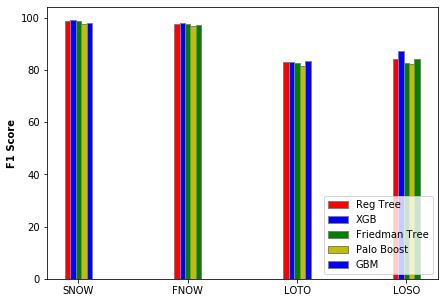

In [12]:
import numpy as np 
import matplotlib.pyplot as plt 
   
# set width of bar 
barWidth = 0.05
fig = plt.subplots(figsize =(7, 5)) 
   
# set height of bar 
Reg = [98.62,97.68,82.92,84.37]
XGB = [99.16,97.97,83.16,87.43]
Friedman=[98.89,97.63,82.73,82.72]
palo=[97.73,96.74,81.35,82.38]
gbm=[98.01,97.09,83.42,84.26]
#CSE = [29, 3, 24, 25, 17] 
   
# Set position of bar on X axis 
br1 = np.arange(4) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
br5 = [x + barWidth for x in br4] 
#br3 = [x + barWidth for x in br2] 
   
# Make the plot 
p1=plt.bar(br1, Reg, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Reg Tree') 
p2=plt.bar(br2, XGB, color ='b', width = barWidth, 
        edgecolor ='grey', label ='XGB')
p3=plt.bar(br3, Friedman, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Friedman Tree')
p4=plt.bar(br4, palo, color ='y', width = barWidth, 
        edgecolor ='grey', label ='Palo Boost')
p5=plt.bar(br5, gbm, color ='bg', width = barWidth, 
        edgecolor ='grey', label ='GBM')
#plt.bar(br3, CSE, color ='b', width = barWidth, 
#        edgecolor ='grey', label ='CSE') 
   
# Adding Xticks  
plt.xlabel('', fontweight ='bold') 
plt.ylabel('F1 Score', fontweight ='bold') 
plt.xticks([r + 0.1 for r in range(4)], 
           ['SNOW', 'FNOW', 'LOTO', 'LOSO']) 
plt.legend((p1[0], p2[0],p3[0],p4[0],p5[0]), ('Reg Tree', 'XGB','Friedman Tree','Palo Boost','GBM'),loc='lower right') 
#plt.title('Comparison of Mean Accuracies with benchmark paper ') 
plt.show() 

In [2]:
import time
t1=time.time()
print(time.time()-t1)
t1=time.time()
time.sleep(10)
print(time.time()-t1)

0.00012993812561035156
10.000923871994019
